This is going to be a very complicated program, I don't know if I can do it well or not.

Let us first create the backend calculations that we will be using.

In [1]:
from typing import Union, Tuple, List
from numbers import Number

## Numpy types
from numpy import ndarray

## Torch types
try:
    from torch import Tensor
except ImportError:
    Tensor = None

## Backend types
if Tensor is not None:
    Tensorlike = Union[ndarray, Tensor]
else:
    Tensorlike = ndarray

## Composite types
ListOrSlice = Union[List[int], slice]
IntOrSlice = Union[int, slice]


In [2]:
# Numpy Backend
import numpy 

# Base Class
class Backend:
    """ Backend Base Class """

    # constants
    pi = numpy.pi

    def __repr__(self):
        return self.__class__.__name__


# Numpy Backend
class NumpyBackend(Backend):
    """ Numpy Backend """

    # types
    int = numpy.int64
    """ integer type for array"""

    float = numpy.float64
    """ floating type for array """

    # methods
    exp = staticmethod(numpy.exp)
    """ exponential of all elements in array """

    sin = staticmethod(numpy.sin)
    """ sine of all elements in array """

    cos = staticmethod(numpy.cos)
    """ cosine of all elements in array """

    sum = staticmethod(numpy.sum)
    """ sum elements in array """

    stack = staticmethod(numpy.stack)
    """ stack multiple arrays """

    transpose = staticmethod(numpy.transpose)
    """ transpose array by flipping two dimensions """

    reshape = staticmethod(numpy.reshape)
    """ reshape array into given shape """

    squeeze = staticmethod(numpy.squeeze)
    """ remove dim-1 dimensions """

    @staticmethod
    def bmm(arr1, arr2):
        """ batch matrix multiply two arrays """
        return numpy.einsum("ijk,ikl->ijl", arr1, arr2)

    @staticmethod
    def is_array(arr):
        """ check if an object is an array """
        return isinstance(arr, numpy.ndarray)

    # constructors
    array = staticmethod(numpy.array)
    """ create an array from an array-like sequence """

    ones = staticmethod(numpy.ones)
    """ create an array filled with ones """

    zeros = staticmethod(numpy.zeros)
    """ create an array filled with zeros """

    linspace = staticmethod(numpy.linspace)
    """ create a linearly spaced array between two points """

    arange = staticmethod(numpy.arange)
    """ create a range of values """

    numpy = staticmethod(numpy.asarray)
    """ convert the array to numpy array """

backend = NumpyBackend()


## Set backend
def set_backend(name: str):
    if name == "numpy":
        backend.__class__ = NumpyBackend
    else:
        raise RuntimeError(f'unknown backend "{name}"')

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as ptc


def visualize(
    grid,
    x=None,
    y=None,
    z=None,
    cmap="Blues",
    pbcolor="C3",
    objcolor=(1, 0, 0, 0.1),
    srccolor="C0",
    detcolor="C2",
    show=True,
):
    # imports (placed here to circumvent circular imports)

    # validate x, y and z
    if x is not None:
        if not isinstance(x, int):
            raise ValueError("the `x`-location supplied should be a single integer")
        if y is not None or z is not None:
            raise ValueError(
                "if an `x`-location is supplied, one should not supply a `y` or a `z`-location!"
            )
    elif y is not None:
        if not isinstance(y, int):
            raise ValueError("the `y`-location supplied should be a single integer")
        if z is not None or x is not None:
            raise ValueError(
                "if a `y`-location is supplied, one should not supply a `z` or a `x`-location!"
            )
    elif z is not None:
        if not isinstance(z, int):
            raise ValueError("the `z`-location supplied should be a single integer")
        if x is not None or y is not None:
            raise ValueError(
                "if a `z`-location is supplied, one should not supply a `x` or a `y`-location!"
            )
    else:
        raise ValueError(
            "at least one projection plane (x, y or z) should be supplied to visualize the grid!"
        )

    # just to create the right legend entries:
    plt.plot([], lw=7, color=objcolor, label="Objects")

    plt.plot([], lw=3, color=srccolor, label="Sources")


    # Grid energy
    grid_energy = backend.sum(grid.E ** 2 + grid.H ** 2, -1)
    if x is not None:
        assert grid.Ny > 1 and grid.Nz > 1
        xlabel, ylabel = "y", "z"
        Nx, Ny = grid.Ny, grid.Nz

        grid_energy = grid_energy[x, :, :]
    elif y is not None:
        assert grid.Nx > 1 and grid.Nz > 1
        xlabel, ylabel = "z", "x"
        Nx, Ny = grid.Nz, grid.Nx

        grid_energy = grid_energy[:, y, :].T
    elif z is not None:
        assert grid.Nx > 1 and grid.Ny > 1
        xlabel, ylabel = "x", "y"
        Nx, Ny = grid.Nx, grid.Ny

        grid_energy = grid_energy[:, :, z]
    else:
        raise ValueError("Visualization only works for 2D grids")

    for source in grid.sources:
       

        if isinstance(source, PointSource):
            if x is not None:
                _x = source.y
                _y = source.z
            elif y is not None:
                _x = source.z
                _y = source.y
            elif z is not None:
                _x = source.x
                _y = source.y
            plt.plot(_y - 0.5, _x - 0.5, lw=3, marker="o", color=srccolor)

        grid_energy[_x, _y] = 0  # do not visualize energy at location of source

    



    for obj in grid.objects:
        if x is not None:
            _x = (obj.y.start, obj.y.stop)
            _y = (obj.z.start, obj.z.stop)
        elif y is not None:
            _x = (obj.z.start, obj.z.stop)
            _y = (obj.x.start, obj.x.stop)
        elif z is not None:
            _x = (obj.x.start, obj.x.stop)
            _y = (obj.y.start, obj.y.stop)

        patch = ptc.Rectangle(
            xy=(min(_y) - 0.5, min(_x) - 0.5),
            width=max(_y) - min(_y),
            height=max(_x) - min(_x),
            linewidth=0,
            edgecolor="none",
            facecolor=objcolor,
        )
        plt.gca().add_patch(patch)

    # visualize the energy in the grid
    plt.imshow(backend.numpy(grid_energy), cmap=cmap, interpolation="sinc")

    # finalize the plot
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    plt.ylim(Nx, -1)
    plt.xlim(-1, Ny)
    plt.figlegend()
    plt.tight_layout()
    if show:
        plt.show()


In [4]:
from math import pi

# 3rd party
from tqdm import tqdm



## Constants
SPEED_LIGHT: float = 299_792_458.0  # [m/s] speed of light
VACUUM_PERMEABILITY: float = 4e-7 * pi  # vacuum permeability
VACUUM_PERMITTIVITY: float = 1.0 / (
    VACUUM_PERMEABILITY * SPEED_LIGHT ** 2
)  # vacuum permittivity


## Functions
def curl_E(E: Tensorlike) -> Tensorlike:
    curl = backend.zeros(E.shape)

    curl[:, :-1, :, 0] += E[:, 1:, :, 2] - E[:, :-1, :, 2]
    curl[:, :, :-1, 0] -= E[:, :, 1:, 1] - E[:, :, :-1, 1]

    curl[:, :, :-1, 1] += E[:, :, 1:, 0] - E[:, :, :-1, 0]
    curl[:-1, :, :, 1] -= E[1:, :, :, 2] - E[:-1, :, :, 2]

    curl[:-1, :, :, 2] += E[1:, :, :, 1] - E[:-1, :, :, 1]
    curl[:, :-1, :, 2] -= E[:, 1:, :, 0] - E[:, :-1, :, 0]

    return curl


def curl_H(H: Tensorlike) -> Tensorlike:

    curl = backend.zeros(H.shape)

    curl[:, 1:, :, 0] += H[:, 1:, :, 2] - H[:, :-1, :, 2]
    curl[:, :, 1:, 0] -= H[:, :, 1:, 1] - H[:, :, :-1, 1]

    curl[:, :, 1:, 1] += H[:, :, 1:, 0] - H[:, :, :-1, 0]
    curl[1:, :, :, 1] -= H[1:, :, :, 2] - H[:-1, :, :, 2]

    curl[1:, :, :, 2] += H[1:, :, :, 1] - H[:-1, :, :, 1]
    curl[:, 1:, :, 2] -= H[:, 1:, :, 0] - H[:, :-1, :, 0]

    return curl


## FDTD Grid Class
class Grid:


    def __init__(
        self,
        shape: Tuple[Number, Number, Number],
        grid_spacing: float = 155e-9,
        permittivity: float = 1.0,
        permeability: float = 1.0,
        courant_number: float = None,
    ):
      
        # save the grid spacing
        self.grid_spacing = float(grid_spacing)

        # save grid shape as integers
        self.Nx, self.Ny, self.Nz = self._handle_tuple(shape)

        # dimension of the simulation:
        self.D = int(self.Nx > 1) + int(self.Ny > 1) + int(self.Nz > 1)

        # courant number of the simulation (optimal value)
        max_courant_number = float(self.D) ** (-0.5)
        if courant_number is None:
            # slight stability factor added
            self.courant_number = 0.99 * max_courant_number
        elif courant_number > max_courant_number:
            raise ValueError(
                f"courant_number {courant_number} too high for "
                f"a {self.D}D simulation"
            )
        else:
            self.courant_number = float(courant_number)

        # timestep of the simulation
        self.time_step = self.courant_number * self.grid_spacing / SPEED_LIGHT

        # save electric and magnetic field
        self.E = backend.zeros((self.Nx, self.Ny, self.Nz, 3))
        self.H = backend.zeros((self.Nx, self.Ny, self.Nz, 3))

        # save the inverse of the relative permittiviy and the relative permeability
        # these tensors can be anisotropic!

        if backend.is_array(permittivity) and len(permittivity.shape) == 3:
            permittivity = permittivity[:, :, :, None]
        self.inverse_permittivity = backend.ones((self.Nx, self.Ny, self.Nz, 3)) / float(
            permittivity
        )

        if backend.is_array(permeability) and len(permeability.shape) == 3:
            permeability = permeability[:, :, :, None]
        self.inverse_permeability = backend.ones((self.Nx, self.Ny, self.Nz, 3)) / float(
            permeability
        )

        # save current time index
        self.time_steps_passed = 0

        # dictionary containing the sources:
        self.sources = []

        # dictionary containing the boundaries
        self.boundaries = []

        # dictionary containing the detectors
        self.detectors = []

        # dictionary containing the objects in the grid
        self.objects = []

    def _handle_distance(self, distance: Number) -> int:
        """ transform a distance to an integer number of gridpoints """
        if not isinstance(distance, int):
            return int(float(distance) / self.grid_spacing + 0.5)
        return distance

    def _handle_time(self, time: Number) -> int:
        """ transform a time value to an integer number of timesteps """
        if not isinstance(time, int):
            return int(float(time) / self.time_step + 0.5)
        return time

    def _handle_tuple(
        self, shape: Tuple[Number, Number, Number]
    ) -> Tuple[int, int, int]:
        """ validate the grid shape and transform to a length-3 tuple of ints """
        if len(shape) != 3:
            raise ValueError(
                f"invalid grid shape {shape}\n"
                f"grid shape should be a 3D tuple containing floats or ints"
            )
        x, y, z = shape
        x = self._handle_distance(x)
        y = self._handle_distance(y)
        z = self._handle_distance(z)
        return x, y, z

    def _handle_slice(self, s: slice) -> slice:
        """ validate the slice and transform possibly float values to ints """
        start = (
            s.start
            if not isinstance(s.start, float)
            else self._handle_distance(s.start)
        )
        stop = (
            s.stop if not isinstance(s.stop, float) else self._handle_distance(s.stop)
        )
        step = (
            s.step if not isinstance(s.step, float) else self._handle_distance(s.step)
        )
        return slice(start, stop, step)

    def _handle_single_key(self, key):
        """ transform a single index key to a slice or list """
        try:
            len(key)
            return [self._handle_distance(k) for k in key]
        except TypeError:
            if isinstance(key, slice):
                return self._handle_slice(key)
            else:
                return [self._handle_distance(key)]
        return key

    @property
    def x(self) -> int:
        """ get the number of grid cells in the x-direction """
        return self.Nx * self.grid_spacing

    @property
    def y(self) -> int:
        """ get the number of grid cells in the y-direction """
        return self.Ny * self.grid_spacing

    @property
    def z(self) -> int:
        """ get the number of grid cells in the y-direction """
        return self.Nz * self.grid_spacing

    @property
    def shape(self) -> Tuple[int, int, int]:
        """ get the shape of the FDTD grid """
        return (self.Nx, self.Ny, self.Nz)

    @property
    def time_passed(self) -> float:
        """ get the total time passed """
        return self.time_steps_passed * self.time_step

    def run(self, total_time: Number, progress_bar: bool = True):
        if isinstance(total_time, float):
            total_time /= self.time_step
        time = range(0, int(total_time), 1)
        if progress_bar:
            time = tqdm(time)
        for _ in time:
            self.step()

    def step(self):

        self.update_E()
        self.update_H()
        self.time_steps_passed += 1

    def update_E(self):

        # update boundaries: step 1
        for boundary in self.boundaries:
            boundary.update_phi_E()

        curl = curl_H(self.H)
        self.E += self.courant_number * self.inverse_permittivity * curl

        # update objects
        for obj in self.objects:
            obj.update_E(curl)

        # update boundaries: step 2
        for boundary in self.boundaries:
            boundary.update_E()

        # add sources to grid:
        for src in self.sources:
            src.update_E()

        # detect electric field
        for det in self.detectors:
            det.detect_E()

    def update_H(self):

        # update boundaries: step 1
        for boundary in self.boundaries:
            boundary.update_phi_H()

        curl = curl_E(self.E)
        self.H -= self.courant_number * self.inverse_permeability * curl

        # update objects
        for obj in self.objects:
            obj.update_H(curl)

        # update boundaries: step 2
        for boundary in self.boundaries:
            boundary.update_H()

        # add sources to grid:
        for src in self.sources:
            src.update_H()

        # detect electric field
        for det in self.detectors:
            det.detect_H()

    def reset(self):
        """ reset the grid by setting all fields to zero """
        self.H *= 0.0
        self.E *= 0.0
        self.time_steps_passed *= 0

    def add_source(self, name, source):
        """ add a source to the grid """
        source._register_grid(self)
        self.sources[name] = source

    def add_boundary(self, name, boundary):
        """ add a boundary to the grid """
        boundary._register_grid(self)
        self.boundaries[name] = boundary

    def add_detector(self, name, detector):
        """ add a detector to the grid """
        detector._register_grid(self)
        self.detectors[name] = detector

    def add_object(self, name, obj):
        """ add an object to the grid """
        obj._register_grid(self)
        self.objects[name] = obj

    def __setitem__(self, key, attr):
        if not isinstance(key, tuple):
            x, y, z = key, slice(None), slice(None)
        elif len(key) == 1:
            x, y, z = key[0], slice(None), slice(None)
        elif len(key) == 2:
            x, y, z = key[0], key[1], slice(None)
        elif len(key) == 3:
            x, y, z = key
        else:
            raise KeyError("maximum number of indices for the grid is 3")

        attr._register_grid(
            grid=self,
            x=self._handle_single_key(x),
            y=self._handle_single_key(y),
            z=self._handle_single_key(z),
        )

    def __repr__(self):
        return (
            f"{self.__class__.__name__}(shape=({self.Nx},{self.Ny},{self.Nz}), "
            f"grid_spacing={self.grid_spacing:.2e}, courant_number={self.courant_number:.2f})"
        )

    def __str__(self):
        """ string representation of the grid
        lists all the components and their locations in the grid.
        """
        s = repr(self) + "\n"
        if self.sources:
            s = s + "\nsources:\n"
            for src in self.sources:
                s += str(src)
        if self.detectors:
            s = s + "\ndetectors:\n"
            for det in self.detectors:
                s += str(det)
        if self.boundaries:
            s = s + "\nboundaries:\n"
            for bnd in self.boundaries:
                s += str(bnd)
        if self.objects:
            s = s + "\nobjects:\n"
            for obj in self.objects:
                s += str(obj)
        return s

In [5]:
class Object:
    """ An object to place in the grid """

    def __init__(self, permittivity: Tensorlike, name: str = None):

        self.grid = None
        self.name = name
        self.permittivity = permittivity

    def _register_grid(
        self, grid: Grid, x: ListOrSlice, y: ListOrSlice, z: ListOrSlice
    ):

        self.grid = grid
        self.grid.objects.append(self)
        if self.name is not None:
            if not hasattr(grid, self.name):
                setattr(grid, self.name, self)
            else:
                raise ValueError(
                    f"The grid already has an attribute with name {self.name}"
                )
        self.x = self._handle_slice(x, max_index=self.grid.Nx)
        self.y = self._handle_slice(y, max_index=self.grid.Ny)
        self.z = self._handle_slice(z, max_index=self.grid.Nz)

        self.Nx = abs(self.x.stop - self.x.start)
        self.Ny = abs(self.y.stop - self.y.start)
        self.Nz = abs(self.z.stop - self.z.start)

        # set the permittivity of the object
        if backend.is_array(self.permittivity) and len(self.permittivity.shape) == 3:
            self.permittivity = self.permittivity[:, :, :, None]
        self.inverse_permittivity = (
            backend.ones((self.Nx, self.Ny, self.Nz, 3)) / self.permittivity
        )

        # set the permittivity values of the object at its border to be equal
        # to the grid permittivity. This way, the object is made symmetric.
        if self.Nx > 1:
            self.inverse_permittivity[-1, :, :, 0] = self.grid.inverse_permittivity[
                -1, self.y, self.z, 0
            ]
        if self.Ny > 1:
            self.inverse_permittivity[:, -1, :, 1] = self.grid.inverse_permittivity[
                self.x, -1, self.z, 1
            ]
        if self.Nz > 1:
            self.inverse_permittivity[:, :, -1, 2] = self.grid.inverse_permittivity[
                self.x, self.y, -1, 2
            ]

        self.grid.inverse_permittivity[self.x, self.y, self.z] = 0

    def _handle_slice(self, s: ListOrSlice, max_index: int = None) -> slice:
        if isinstance(s, list):
            if len(s) == 1:
                return slice(s[0], s[0] + 1, None)
            raise IndexError(
                "One can only use slices or single indices to index the grid for an Object"
            )
        if isinstance(s, slice):
            start, stop, step = s.start, s.stop, s.step
            if step is not None and step != 1:
                raise IndexError(
                    "Can only use slices with unit step to index the grid for an Object"
                )
            if start is None:
                start = 0
            if start < 0:
                start = max_index + start
            if stop is None:
                stop = max_index
            if stop < 0:
                stop = max_index + stop
            return slice(start, stop, None)
        raise ValueError("Invalid grid indexing used for object")

    def update_E(self, curl_H):
 
        loc = (self.x, self.y, self.z)
        self.grid.E[loc] += (
            self.grid.courant_number * self.inverse_permittivity * curl_H[loc]
        )

    def update_H(self, curl_E):


    def __repr__(self):
        return f"{self.__class__.__name__}(name={repr(self.name)})"

    def __str__(self):
        s = "    " + repr(self) + "\n"

        def _handle_slice(s):
            return (
                str(s)
                .replace("slice(", "")
                .replace(")", "")
                .replace(", ", ":")
                .replace("None", "")
            )

        x = _handle_slice(self.x)
        y = _handle_slice(self.y)
        z = _handle_slice(self.z)
        s += f"        @ x={x}, y={y}, z={z}".replace(":,", ",")
        if s[-1] == ":":
            s = s[:-1]
        return s + "\n"


In [6]:
from math import pi, sin



## PointSource class
class PointSource:
    """ A source placed at a single point (grid cell) in the grid """

    def __init__(
        self,
        period: Number = 15,
        power: float = 1.0,
        phase_shift: float = 0.0,
        name: str = None,
    ):

        self.grid = None
        self.period = period
        self.power = power
        self.phase_shift = phase_shift
        self.name = name

    def _register_grid(self, grid: Grid, x: Number, y: Number, z: Number):

        self.grid = grid
        self.grid.sources.append(self)
        if self.name is not None:
            if not hasattr(grid, self.name):
                setattr(grid, self.name, self)
            else:
                raise ValueError(
                    f"The grid already has an attribute with name {self.name}"
                )

        try:
            (x,), (y,), (z,) = x, y, z
        except (TypeError, ValueError):
            raise ValueError("a point source should be placed on a single grid cell.")
        self.x, self.y, self.z = grid._handle_tuple((x, y, z))
        self.period = grid._handle_time(self.period)
        self.amplitude = (
            self.power * self.grid.inverse_permittivity[self.x, self.y, self.z, 2]
        ) ** 0.5

    def update_E(self):
        """ Add the source to the electric field """
        q = self.grid.time_steps_passed
        src = self.amplitude * sin(2 * pi * q / self.period + self.phase_shift)
        self.grid.E[self.x, self.y, self.z, 2] += src

    def update_H(self):
        """ Add the source to the magnetic field """

    def __repr__(self):
        return (
            f"{self.__class__.__name__}(period={self.period}, "
            f"power={self.power}, phase_shift={self.phase_shift}, "
            f"name={repr(self.name)})"
        )

    def __str__(self):
        s = "    " + repr(self) + "\n"
        x = f"{self.x}"
        y = f"{self.y}"
        z = f"{self.z}"
        s += f"        @ x={x}, y={y}, z={z}\n"
        return s


Grid(shape=(161,161,1), grid_spacing=1.55e-07, courant_number=0.70)

sources:
    PointSource(period=14, power=1.0, phase_shift=0.0, name='pointsource')
        @ x=80, y=80, z=0

courant number: 0.7000357133746821


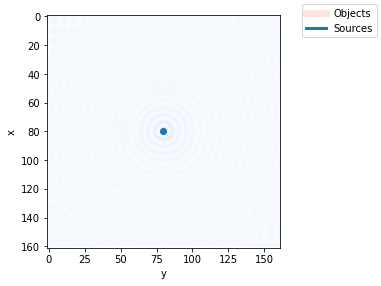

In [10]:
set_backend("numpy")


## Constants
WAVELENGTH = 1550e-9
SPEED_LIGHT: float = 299_792_458.0  # [m/s] speed of light


## Simulation

# create FDTD Grid
grid = Grid(
    (2.5e-5, 2.5e-5, 1),
    grid_spacing=0.1 * WAVELENGTH,
    permittivity=1.0,
    permeability=1.0,
)


grid[80, 80, 0] = PointSource(
    period=WAVELENGTH / SPEED_LIGHT, name="pointsource",
)





print(grid)
print(f"courant number: {grid.courant_number}")

# run simulation
grid.run(200, progress_bar=False)


## Plots

# Fields
if True:
    fig, axes = plt.subplots(2, 3, squeeze=False)
    titles = ["Ex: xy", "Ey: xy", "Ez: xy", "Hx: xy", "Hy: xy", "Hz: xy"]

    fields = backend.stack(
        [
            grid.E[:, :, 0, 0],
            grid.E[:, :, 0, 1],
            grid.E[:, :, 0, 2],
            grid.H[:, :, 0, 0],
            grid.H[:, :, 0, 1],
            grid.H[:, :, 0, 2],
        ]
    )

    m = max(abs(fields.min().item()), abs(fields.max().item()))

    for ax, field, title in zip(axes.ravel(), fields, titles):
        ax.set_axis_off()
        ax.set_title(title)
        ax.imshow(backend.numpy(field), vmin=-m, vmax=m, cmap="RdBu")

    plt.show()


# Visualize Grid
if True:
    plt.figure()
    visualize(grid,z=0)

Grid(shape=(161,161,1), grid_spacing=1.55e-07, courant_number=0.70)

sources:
    PointSource(period=14, power=1.0, phase_shift=0.0, name='pointsource')
        @ x=80, y=80, z=0

objects:
    Object(name='object1')
        @ x=0:79, y=0:79, z=0:1
    Object(name='object2')
        @ x=0:79, y=80:160, z=0:1
    Object(name='object3')
        @ x=80:160, y=0:79, z=0:1
    Object(name='object4')
        @ x=80:160, y=80:160, z=0:1

courant number: 0.7000357133746821


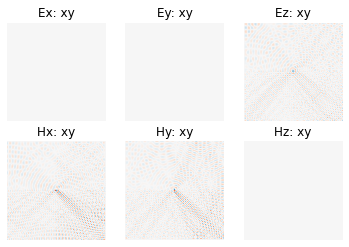

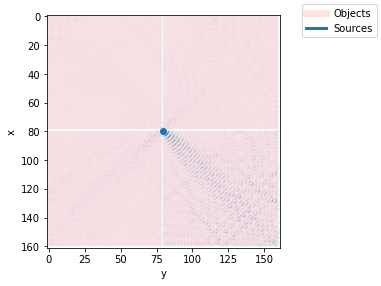

In [7]:
set_backend("numpy")


## Constants
WAVELENGTH = 1550e-9
SPEED_LIGHT: float = 299_792_458.0  # [m/s] speed of light


## Simulation

# create FDTD Grid
grid = Grid(
    (2.5e-5, 2.5e-5, 1),
    grid_spacing=0.1 * WAVELENGTH,
    permittivity=1.0,
    permeability=1.0,
)


grid[80, 80, 0] = PointSource(
    period=WAVELENGTH / SPEED_LIGHT, name="pointsource",
)

grid[0:79, 0:79, 0:1] = Object(permittivity=1.5, name="object1")
grid[0:79, 80:160, 0:1] = Object(permittivity=2.5, name="object2")
grid[80:160, 0:79, 0:1] = Object(permittivity=3.5, name="object3")
grid[80:160, 80:160, 0:1] = Object(permittivity=4.5, name="object4")





print(grid)
print(f"courant number: {grid.courant_number}")

# run simulation
grid.run(1000, progress_bar=False)


## Plots

# Fields
if True:
    fig, axes = plt.subplots(2, 3, squeeze=False)
    titles = ["Ex: xy", "Ey: xy", "Ez: xy", "Hx: xy", "Hy: xy", "Hz: xy"]

    fields = backend.stack(
        [
            grid.E[:, :, 0, 0],
            grid.E[:, :, 0, 1],
            grid.E[:, :, 0, 2],
            grid.H[:, :, 0, 0],
            grid.H[:, :, 0, 1],
            grid.H[:, :, 0, 2],
        ]
    )

    m = max(abs(fields.min().item()), abs(fields.max().item()))

    for ax, field, title in zip(axes.ravel(), fields, titles):
        ax.set_axis_off()
        ax.set_title(title)
        ax.imshow(backend.numpy(field), vmin=-m, vmax=m, cmap="RdBu")

    plt.show()


# Visualize Grid
if True:
    plt.figure()
    visualize(grid,z=0)